In [1]:
import pandas as pd
import numpy as np

# Limpieza de datos
import re
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score, train_test_split
from pattern.text.en import singularize, lemma
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Modelos
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [2]:
data = pd.read_csv("./VirusSample.csv", usecols=lambda x: 'Unnamed' not in x)
print(len(data))
data.head()

9795


,file,api,class
0,7ff49f2f0912352416b05c010f35f402cc79feed,"IntersectRect,GetCurrentProcess,GetVersion",Virus
1,50cc6c99ec285d0db45dde07d8fdc18d9098c5b6,"GetCaretBlinkTime,CountClipboardFormats,GetCon...",Virus
2,f77c6bd4aebacd1a01d02e0cb20642ebf2d32929,"VarR8Pow,GetClipboardViewer,GetInputDesktop,Ge...",Virus
3,349c367c5b88fbb6cafae5d7109588d7250e16b5,"SetTraceCallback,CopyAcceleratorTableW,GetProc...",Virus
4,021f4aa86b520e1d606ab26699c35546bcd00c27,"SHLoadNonloadedIconOverlayIdentifiers,VarUI8Fr...",Virus


# Limpiando data

In [3]:
cachedStopWords = stopwords.words('english')
def removeStepWords(value):
  return ' '.join([word for word in value.split(',') if word not in cachedStopWords])

data["api"] = data["api"].apply(removeStepWords)

In [4]:
def parseLemma(value):
  try:
    return lemma(value)
  except:
    return value

def sentenceToPresent(value):
  items = value.split(' ')
  for item in items:
    present = parseLemma(item)
    value = value.replace(item, present)
  return value

data["api"] = data["api"].apply(sentenceToPresent)

In [5]:
def toSingular(value):
  try:
    return singularize(value)
  except:
    return value
    
def sentenceToSingular(value):
  items = value.split(' ')
  for item in items:
    singular = toSingular(item)
    value = value.replace(item, singular)
  return value

data["api"] = data["api"].apply(sentenceToSingular)

In [6]:
def removeSpecialChars(value):
    ayuda = re.sub(r"[^a-zA-Z ]",' ', value.lower())
    return ayuda

data["api"] = data["api"].apply(removeSpecialChars)

In [7]:
def removeExtraSpaces(value):
    return re.sub('  +', ' ', value) 

data["api"] = data["api"].apply(removeExtraSpaces)

In [8]:
data.drop(data[data["api"] == "empty"].index, inplace=True)

In [9]:
data.head()

,file,api,class
0,7ff49f2f0912352416b05c010f35f402cc79feed,intersectrect getcurrentproce getversion,Virus
1,50cc6c99ec285d0db45dde07d8fdc18d9098c5b6,getcaretblinktime countclipboardformat getcons...,Virus
2,f77c6bd4aebacd1a01d02e0cb20642ebf2d32929,varr pow getclipboardviewer getinputdesktop ge...,Virus
3,349c367c5b88fbb6cafae5d7109588d7250e16b5,settracecallback copyacceleratortablew getproc...,Virus
4,021f4aa86b520e1d606ab26699c35546bcd00c27,shloadnonloadediconoverlayidentifier varui fro...,Virus


In [10]:
print(data['class'].value_counts())

Trojan        6153
Virus         2367
Backdoor       447
Worms          441
Adware         222
Agent          102
Downloader      31
Spyware         11
Ransomware      10
Dropper          4
Riskware         4
Crypt            2
Keylogger        1
Name: class, dtype: int64


In [11]:
viruses_list = data['class'].unique()
balancedDf = pd.DataFrame(columns=data.columns)

for virus in viruses_list:
    selected_data = data.loc[data['class'] == virus][0:300]
    if (len(selected_data) >= 80):
        balancedDf = pd.concat([balancedDf, selected_data])

print(balancedDf['class'].value_counts())

Backdoor    300
Virus       300
Trojan      300
Worms       300
Adware      222
Agent       102
Name: class, dtype: int64


# Wordcloud

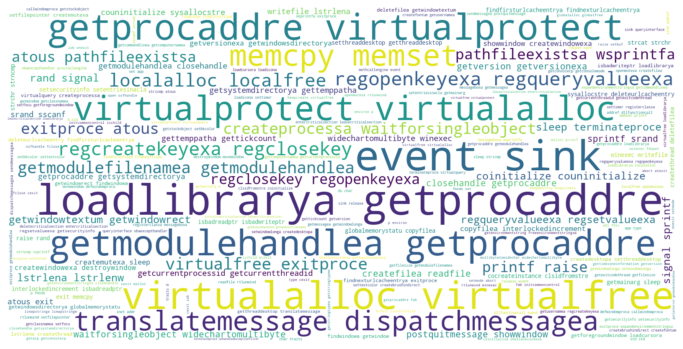

In [12]:
# wordcloud 
body_strings = data["api"].to_list()
body_strings = pd.Series(body_strings).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(body_strings)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [13]:
keyToVal = {}
valToKey = {}
for i, item in enumerate(list(data['class'].unique())):
  keyToVal[i] = item
  valToKey[item] = i

In [14]:
def replaceValToKey(value):
  return valToKey[value] 

data['class'] = data['class'].apply(replaceValToKey)

In [15]:
data.head()

,file,api,class
0,7ff49f2f0912352416b05c010f35f402cc79feed,intersectrect getcurrentproce getversion,0
1,50cc6c99ec285d0db45dde07d8fdc18d9098c5b6,getcaretblinktime countclipboardformat getcons...,0
2,f77c6bd4aebacd1a01d02e0cb20642ebf2d32929,varr pow getclipboardviewer getinputdesktop ge...,0
3,349c367c5b88fbb6cafae5d7109588d7250e16b5,settracecallback copyacceleratortablew getproc...,0
4,021f4aa86b520e1d606ab26699c35546bcd00c27,shloadnonloadediconoverlayidentifier varui fro...,0


# Modelos

In [16]:
def generate_RF_data(received_df):
    dataBodyList = received_df["api"].to_list()

    bv = CountVectorizer(min_df=0.1, max_df=0.8, ngram_range=(2,10))
    bv_matrix = bv.fit_transform(dataBodyList)
    bv_matrix = bv_matrix.toarray()
    vocabulario = bv.get_feature_names()
    df_bv = pd.DataFrame(bv_matrix, columns=vocabulario)
    
    
    X = bv_matrix
    y = received_df['class']
    print (X.shape) 
    print (y.shape) 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    return [df_bv, X_train, X_test, y_train, y_test]



## Random Forest Classifier (Imbalanced)

In [17]:
df_bv, X_train, X_test, y_train, y_test = generate_RF_data(data)

(9795, 12)
(9795,)


c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
df_bv

,getmodulehandlea getprocaddre,getprocaddre virtualprotect,getprocaddre virtualprotect virtualalloc,getprocaddre virtualprotect virtualalloc virtualfree,loadlibrarya getprocaddre,memcpy memset,regcreatekeyexa regclosekey,regopenkeyexa regqueryvalueexa,translatemessage dispatchmessagea,virtualalloc virtualfree,virtualprotect virtualalloc,virtualprotect virtualalloc virtualfree
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9790,0,0,0,0,0,0,0,0,0,0,0,0
9791,0,0,0,0,0,0,0,0,0,0,0,0
9792,0,0,0,0,0,0,0,0,0,0,0,0
9793,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
randomForest = RandomForestClassifier(max_depth=12, random_state=42) 
randomForest = randomForest.fit(X_train, y_train)
y_preds = randomForest.predict(X_test)

In [20]:
print ('Accuracy:\t', accuracy_score(y_test, y_preds))
print ('Precision:\t', precision_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)))
print ('Recall:\t\t', recall_score(y_test, y_preds, average='weighted'))
print ('F1:\t\t', f1_score(y_test, y_preds, average='weighted'))

# print('Cross-Validation', cross_val_score(randomForest, y_test, y_preds, cv=10))

Accuracy:	 0.720653283429738
Precision:	 0.8081590753485351
Recall:		 0.720653283429738
F1:		 0.7033449799681063


## Random Forest Classifier (Balanced)

In [44]:
df_bv, X_train, X_test, y_train, y_test = generate_RF_data(balancedDf)

(1524, 124)
(1524,)


c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
df_bv

,cexit malloc,cexit malloc printf,cexit malloc printf raise,cexit malloc printf raise setbuf,cexit malloc printf raise setbuf sprintf,cexit malloc printf raise setbuf sprintf strcpy,closehandle getsystemdirectorya,closehandle getsystemdirectorya openmutexa,closehandle getsystemdirectorya openmutexa rtlunwind,closehandle getsystemdirectorya openmutexa rtlunwind winexec,...,winexec fdopen,winexec fdopen open,winexec fdopen open osfhandle,winexec fdopen open osfhandle fclose,winexec fdopen open osfhandle fclose cexit,winexec fdopen open osfhandle fclose cexit malloc,winexec fdopen open osfhandle fclose cexit malloc printf,winexec fdopen open osfhandle fclose cexit malloc printf raise,winexec fdopen open osfhandle fclose cexit malloc printf raise setbuf,writefile createfilea
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1522,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
randomForest = RandomForestClassifier(max_depth=12, random_state=42) 
randomForest = randomForest.fit(X_train, y_train)
y_preds = randomForest.predict(X_test)

In [47]:
print ('Accuracy:\t', accuracy_score(y_test, y_preds))
print ('Precision:\t', precision_score(y_test, y_preds, average='weighted', labels=np.unique(y_preds)))
print ('Recall:\t\t', recall_score(y_test, y_preds, average='weighted'))
print ('F1:\t\t', f1_score(y_test, y_preds, average='weighted'))

# print('Cross-Validation', cross_val_score(randomForest, y_test, y_preds, cv=10))

Accuracy:	 0.6004366812227074
Precision:	 0.7131168438673263
Recall:		 0.6004366812227074
F1:		 0.5928099490962919


# SVM

In [48]:
#Se transforman las colunas usando los preprocesadores
numeric_preprocessor = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

preprocesador = ColumnTransformer([
    ('numerico', numeric_preprocessor, df_bv)
],remainder="passthrough")

In [49]:
modelo = make_pipeline(preprocesador, SVC(kernel="poly", C=32, degree=4))
modelo = modelo.fit(X_train, y_train)
y_preds = modelo.predict(X_test)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed